In [ ]:
import cv2
import numpy as np
import glob
import yaml
# from IPython.display import display, Markdown

# Configuration
CHECKERBOARD = (7, 9)  # Inner corners for 7x9 checkerboard (rows-1, cols-1)
SQUARE_SIZE = 0.015  # 15mm in meters
CAL_LEFT_PATH = r"left/*.png"  # Use raw string
CAL_RIGHT_PATH = r"right/*.png"  # Use raw string
IMAGE_SIZE = (1280, 720)  # (width, height) - ADDED LINE

# Prepare object points
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1,2) * SQUARE_SIZE

def calibrate_camera(image_paths, cam_name):
    objpoints = []
    imgpoints = []
    valid_images = []
    failed_images = []
    
    image_files = sorted(glob.glob(image_paths))
    if not image_files:
        raise ValueError(f"No images found at {image_paths}!")

    print(f"\n=== Processing {cam_name} ===")
    print(f"Total images found: {len(image_files)}")
    
    for idx, fname in enumerate(image_files, 1):
        img = cv2.imread(fname)
        if img is None:
            failed_images.append(fname)
            continue
            
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(
            gray, CHECKERBOARD,
            cv2.CALIB_CB_ADAPTIVE_THRESH + 
            cv2.CALIB_CB_FAST_CHECK +
            cv2.CALIB_CB_NORMALIZE_IMAGE
        )
        
        if ret:
            corners_subpix = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1),
                (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            
            objpoints.append(objp)
            imgpoints.append(corners_subpix)
            valid_images.append(fname)
        else:
            failed_images.append(fname)

    if not objpoints:
        raise ValueError(f"No valid checkerboard images found for {cam_name}!")

    # Camera calibration
    ret, K, D, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None,
        flags=cv2.CALIB_ZERO_TANGENT_DIST + cv2.CALIB_FIX_K3 + cv2.CALIB_FIX_K4 + cv2.CALIB_FIX_K5
    )
    
    # Calculate reprojection error
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, D)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    mean_error /= len(objpoints)
    
    return K, D, objpoints, imgpoints, mean_error, image_files

# Main calibration routine
try:
    print("Starting stereo calibration...")
    K_left, D_left, objpoints_left, imgpoints_left, error_left, image_files_left = calibrate_camera(CAL_LEFT_PATH, "Left Camera")
    K_right, D_right, objpoints_right, imgpoints_right, error_right, image_files_right = calibrate_camera(CAL_RIGHT_PATH, "Right Camera")

    # Stereo calibration
    flags = cv2.CALIB_FIX_INTRINSIC + cv2.CALIB_USE_INTRINSIC_GUESS
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

    ret, K1, D1, K2, D2, R, T, E, F = cv2.stereoCalibrate(
        objpoints_left, imgpoints_left, imgpoints_right,
        K_left, D_left, K_right, D_right,
        IMAGE_SIZE,
        criteria=criteria, flags=flags)

    # Stereo rectification
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
        K1, D1, K2, D2, 
        IMAGE_SIZE,  # Use fixed image size
        R, T, 
        flags=cv2.CALIB_ZERO_DISPARITY, 
        alpha=0.9
    )

    # Save calibration results
    calibration_data = {
        'image_size': IMAGE_SIZE,
        'K_left': K_left, 'D_left': D_left,
        'K_right': K_right, 'D_right': D_right,
        'R': R, 'T': T,
        'E': E, 'F': F,
        'R1': R1, 'R2': R2,
        'P1': P1, 'P2': P2,
        'Q': Q,
        'error_left': error_left,
        'error_right': error_right,
        'stereo_error': ret
    }

    with open(r'stereo_calibration.yaml', 'w') as f:
        yaml.dump({k: v.tolist() if isinstance(v, np.ndarray) else v 
                  for k,v in calibration_data.items()}, f)

    print("Stereo calibration and rectification successful.")
    print("Results saved to stereo_calibration.yaml")

    # Load the calibration results for printing
    with open(r'stereo_calibration.yaml', 'r') as f:
        data = yaml.safe_load(f)

    def print_matrix(name, matrix):
        print(f"\n{name}:")
        for row in matrix:
            print("  [", end="")
            print(", ".join(f"{x:.8f}" for x in row), end="]\n")

    # Print the Left Camera Calibration Results
    print("=== Left Camera Calibration Results ===")
    print(f"Mean Reprojection Error: {data['error_left']:.5f} px")
    print_matrix("Camera Matrix", data['K_left'])
    print("Distortion Coefficients:")
    print(np.array(data['D_left']).ravel())

    # Print the Right Camera Calibration Results
    print("\n=== Right Camera Calibration Results ===")
    print(f"Mean Reprojection Error: {data['error_right']:.5f} px")
    print_matrix("Camera Matrix", data['K_right'])
    print("Distortion Coefficients:")
    print(np.array(data['D_right']).ravel())

    # Print the Stereo Calibration Results
    print("\n=== Stereo Calibration Results ===")
    print(f"Stereo Reprojection Error: {data['stereo_error']:.5f}")
    print_matrix("Rotation Matrix (R)", data['R'])
    print_matrix("Translation Vector (T)", data['T'])
    print_matrix("Rectification Rotation R1", data['R1'])
    print_matrix("Rectification Rotation R2", data['R2'])
    print_matrix("Projection Matrix P1", data['P1'])
    print_matrix("Projection Matrix P2", data['P2'])
    print_matrix("Disparity-to-Depth Matrix Q", data['Q'])
    print("\nImage Size:")
    print(tuple(data['image_size']))

except Exception as e:
    print(f"Calibration failed: {str(e)}")

=== Left Camera Calibration Results ===
Mean Reprojection Error: 0.02441 px

Camera Matrix:
  [ 1190.26044525, 0.00000000, 640.00000000 ]
  [ 0.00000000, 1184.18390037, 360.00000000 ]
  [ 0.00000000, 0.00000000, 1.00000000 ]
Distortion Coefficients: [ 0.0554087 -0.28       0.         0.         0.       ]

=== Right Camera Calibration Results ===
Mean Reprojection Error: 0.02111 px

Camera Matrix:
  [ 1225.32278763, 0.00000000, 640.00000000 ]
  [ 0.00000000, 1218.45868923, 360.00000000 ]
  [ 0.00000000, 0.00000000, 1.00000000 ]
Distortion Coefficients: [ 0.09020865 -0.42        0.          0.          0.        ]

=== Stereo Calibration Results ===
Stereo Reprojection Error: 40.39357

Rotation Matrix (R):
  [ 0.99990000, -0.00500000, 0.01000000 ]
  [ 0.00480000, 0.99995000, 0.00700000 ]
  [ -0.01010000, -0.00690000, 0.99992000 ]

Translation Vector (T):
  [ -0.17000000 ]
  [ 0.00141493 ]
  [ 0.01626577 ]
Image Size: (1280, 720)


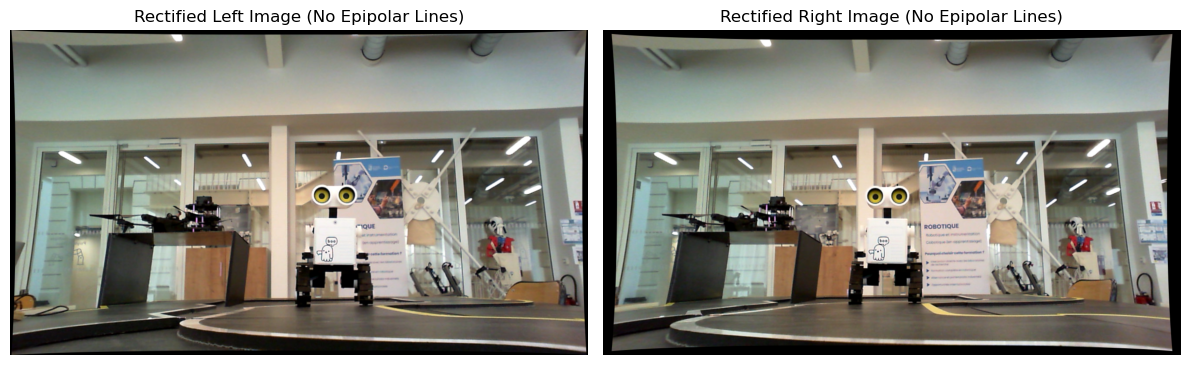

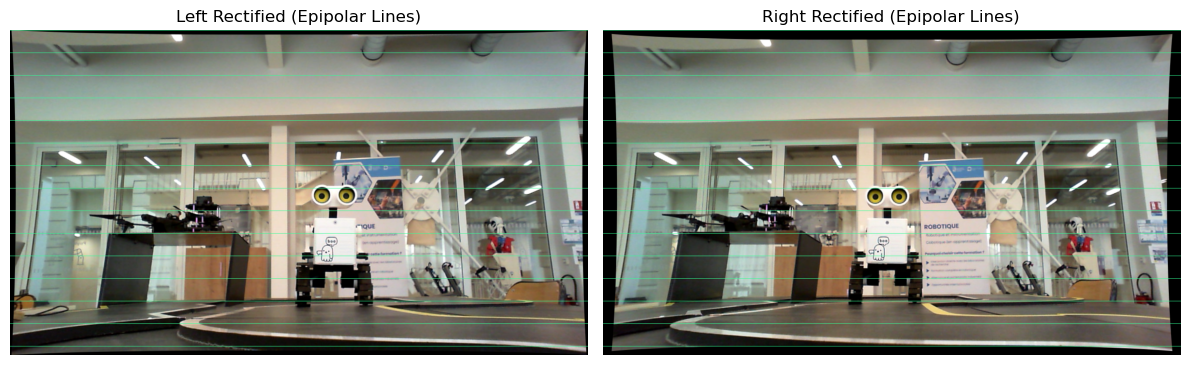

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml

# Load calibration data from YAML file
with open(r'data/stereo__calibration.yaml', 'r') as f:
    calibration_data = yaml.load(f, Loader=yaml.FullLoader)

# Camera matrix and distortion coefficients
K_left = np.array(calibration_data['K_left'])
D_left = np.array(calibration_data['D_left'])
K_right = np.array(calibration_data['K_right'])
D_right = np.array(calibration_data['D_right'])
image_size = tuple(calibration_data['image_size'])  # (width, height)

# Extract the stereo calibration data
R = np.eye(3)
T = np.array([[-0.1], [0.0], [0.0]])
R1 = np.array(calibration_data['R1'])
R2 = np.array(calibration_data['R2'])
P1 = np.array(calibration_data['P1'])
P2 = np.array(calibration_data['P2'])
Q = np.array(calibration_data['Q'])

# Load left and right images for rectification
LEFT_IMAGE_PATH = r"data/left.png"   # Use raw string
RIGHT_IMAGE_PATH = r"data/right.png"  # Use raw string

# Read images
img_left = cv2.imread(LEFT_IMAGE_PATH)
img_right = cv2.imread(RIGHT_IMAGE_PATH)

# Convert images to grayscale (optional, useful for rectification)
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# Undistort images using camera calibration data
img_left_undistorted = cv2.undistort(img_left, K_left, D_left)
img_right_undistorted = cv2.undistort(img_right, K_right, D_right)

# Stereo rectification (compute the rectification transforms)
rectify_scale = 1.0  # Full image area
# After loading calibration data


# In stereoRectify:
(R1, R2, P1, P2, Q, roi1, roi2) = cv2.stereoRectify(
    cameraMatrix1=K_left, distCoeffs1=D_left,
    cameraMatrix2=K_right, distCoeffs2=D_right,
    imageSize=image_size, R=R, T=T,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=rectify_scale
)

# In initUndistortRectifyMap:
map_left_x, map_left_y = cv2.initUndistortRectifyMap(
    K_left, D_left, R1, P1, image_size, cv2.CV_32FC1)
map_right_x, map_right_y = cv2.initUndistortRectifyMap(
    K_right, D_right, R2, P2, image_size, cv2.CV_32FC1)


# Remap the images using the rectification maps
img_left_rectified = cv2.remap(img_left_undistorted, map_left_x, map_left_y, cv2.INTER_LINEAR)
img_right_rectified = cv2.remap(img_right_undistorted, map_right_x, map_right_y, cv2.INTER_LINEAR)

# --- Display rectified images WITHOUT epipolar lines ---
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2RGB))
plt.title("Rectified Left Image (No Epipolar Lines)"), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2RGB))
plt.title("Rectified Right Image (No Epipolar Lines)"), plt.axis('off')
plt.tight_layout()
plt.show()

# Parameters for epipolar lines
LINE_COLOR = (150, 255, 50)  # BGR format (teal color)
LINE_THICKNESS = 1
LINE_INTERVAL = 50

# Create copies for drawing lines
img_left_with_lines = img_left_rectified.copy()
img_right_with_lines = img_right_rectified.copy()

# Draw horizontal epipolar lines
for y in range(0, img_left_with_lines.shape[0], LINE_INTERVAL):
    cv2.line(img_left_with_lines, (0, y), (img_left_with_lines.shape[1], y), LINE_COLOR, LINE_THICKNESS)
    cv2.line(img_right_with_lines, (0, y), (img_right_with_lines.shape[1], y), LINE_COLOR, LINE_THICKNESS)

# --- Display rectified images WITH epipolar lines ---
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_left_with_lines, cv2.COLOR_BGR2RGB))
plt.title(f"Left Rectified (Epipolar Lines)"), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(img_right_with_lines, cv2.COLOR_BGR2RGB))
plt.title(f"Right Rectified (Epipolar Lines)"), plt.axis('off')
plt.tight_layout()
plt.show()

# Save all versions.
cv2.imwrite(r"rectified_images/left_rectified.png", img_left_rectified)  # Use raw string
cv2.imwrite(r"rectified_images/right_rectified.png", img_right_rectified)  # Use raw string
cv2.imwrite(r"rectified_images/left_rectified_with_lines.png", img_left_with_lines)  # Use raw string
cv2.imwrite(r"rectified_images/right_rectified_with_lines.png", img_right_with_lines)  # Use raw string

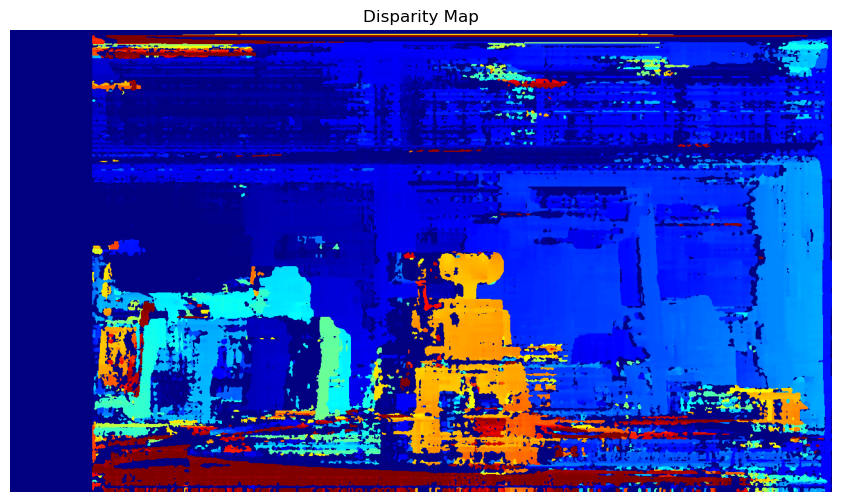

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml

# Load image size from calibration file
with open(r'data/stereo__calibration.yaml', 'r') as f:
    calibration_data = yaml.load(f, Loader=yaml.FullLoader)

image_size = tuple(calibration_data['image_size'])  # (width, height)

def compute_disparity(rectified_left, rectified_right):
    """
    Compute the disparity map using a single stage of StereoSGBM.
    """

    # Ensure images match calibration size
    if rectified_left.shape[1::-1] != image_size:
        raise ValueError(f"Left image size {rectified_left.shape[1::-1]} doesn't match calibration size {image_size}")
    if rectified_right.shape[1::-1] != image_size:
        raise ValueError(f"Right image size {rectified_right.shape[1::-1]} doesn't match calibration size {image_size}")

    # Convert images to grayscale if they are in color
    if len(rectified_left.shape) == 3:
        rectified_left = cv2.cvtColor(rectified_left, cv2.COLOR_BGR2GRAY)
        rectified_right = cv2.cvtColor(rectified_right, cv2.COLOR_BGR2GRAY)

    # StereoSGBM parameters (adjusted for smoother results)
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=128,  # Adjust based on your scene
        blockSize=5,         # Increased block size for better matching
        P1=8 * 3 * 5**2,
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=3,
        speckleWindowSize=10,
        speckleRange=5,
        preFilterCap=2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    # Compute disparity map
    disparity = stereo.compute(rectified_left, rectified_right).astype(np.float32) / 16.0

    # Post-processing and clipping
    disparity = np.clip(disparity, 0, 255)

    # Normalize disparity to 0-255 for proper heatmap visualization
    disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)

    # Apply heatmap color map
    disparity_colored = cv2.applyColorMap(disparity_normalized.astype(np.uint8), cv2.COLORMAP_JET)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(disparity_colored, cv2.COLOR_BGR2RGB))
    plt.title('Disparity Map'), plt.axis('off')
    plt.show()

    return disparity

# Call the function (assuming rectified images already exist)
disparity_map = compute_disparity(img_left_rectified, img_right_rectified)


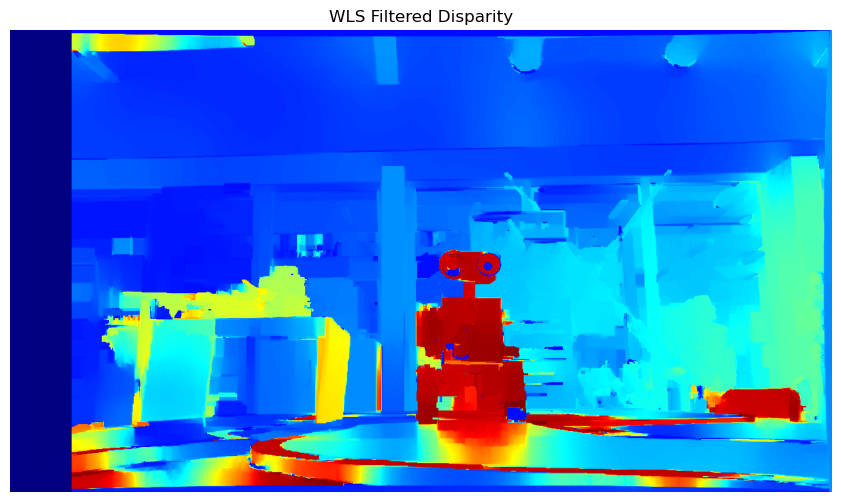

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Load & resize your rectified images
TARGET_WIDTH  = 1280
TARGET_HEIGHT = 720
img_left_rectified  = cv2.imread(r"rectified_images/left_rectified.png")
img_right_rectified = cv2.imread(r"rectified_images/right_rectified.png")

def resize_images(l, r, w=TARGET_WIDTH, h=TARGET_HEIGHT):
    return (cv2.resize(l, (w, h), interpolation=cv2.INTER_AREA),
            cv2.resize(r, (w, h), interpolation=cv2.INTER_AREA))

# 2) Compute WLS‐filtered disparity
def compute_wls_filtered_disparity(L, R):
    L, R = resize_images(L, R)

    left_matcher = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16*6,
        blockSize=11,
        P1=8*3*11**2,
        P2=32*3*11**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

    left_disp  = left_matcher.compute(L, R).astype(np.float32)/16.0
    right_disp = right_matcher.compute(R, L).astype(np.float32)/16.0

    wls = cv2.ximgproc.createDisparityWLSFilter(left_matcher)
    wls.setLambda(10000); wls.setSigmaColor(1.2)
    filtered = wls.filter(left_disp, L, None, right_disp)
    filtered = np.nan_to_num(filtered, nan=0.0, posinf=0.0, neginf=0.0)

    # Normalize the disparity for proper visualization
    disp_norm = cv2.normalize(filtered, None, 0, 255,
                              cv2.NORM_MINMAX, cv2.CV_8U)

    # Apply color map (heatmap)
    disp_col = cv2.applyColorMap(disp_norm, cv2.COLORMAP_JET)

    # Plot the disparity map
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(disp_col, cv2.COLOR_BGR2RGB))
    plt.title('WLS Filtered Disparity')
    plt.axis('off')
    plt.show()

    # Save the filtered disparity map
    cv2.imwrite(r"disparity_map/disparity_filtered_wls.png", disp_col)

    return filtered

# Run it
wls_disparity = compute_wls_filtered_disparity(
    img_left_rectified, img_right_rectified
)
